[INFO] processing image 1/1
1lib-0


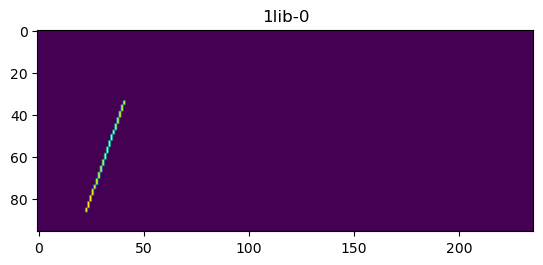

In [3]:
import os
import os.path
import cv2
import glob
from matplotlib import pyplot as plt


CAPTCHA_IMAGE_FOLDER = "train"
OUTPUT_FOLDER = "extracted_letter_images"


# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "1lib-0.png"))
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    print(captcha_correct_text)

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    plt.imshow(image)   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.title(captcha_correct_text)
    plt.imshow(gray)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV )[1]
    plt.imshow(thresh)

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if len(contours) == 2 else contours[1]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)
        

        # increment the count for the current key
        counts[letter_text] = count + 1

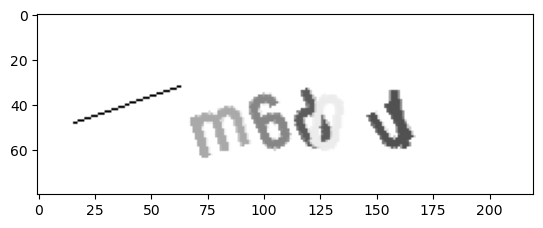

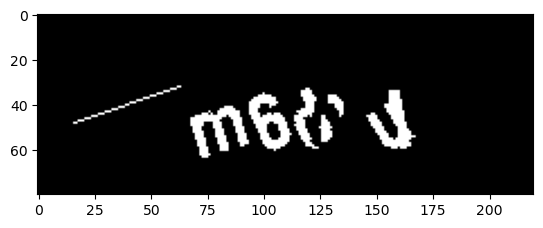

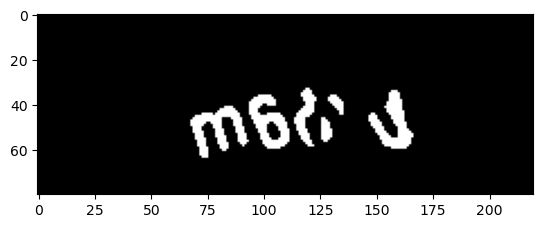

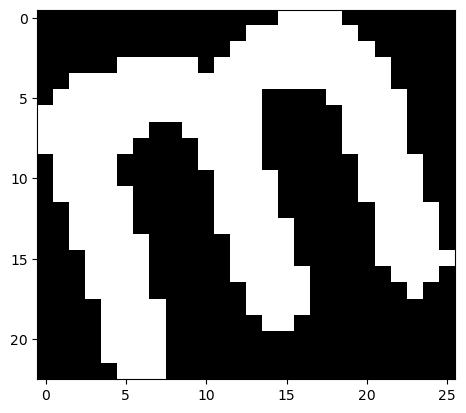

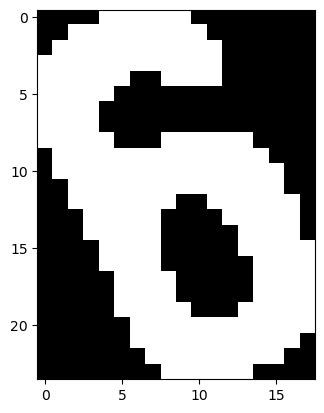

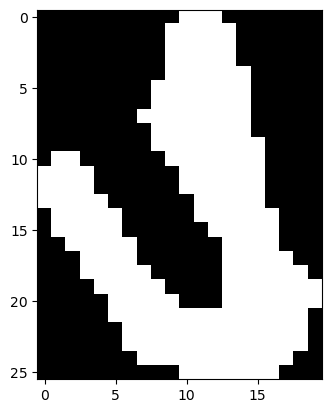

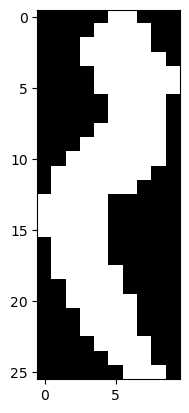

Segmentation completed!


In [15]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
    

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
counts = {}

# Load the CAPTCHA image
image_path = "train/m6d0ul-0.png"  
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)

plt.imshow(im_bw_inverted, cmap='gray')
plt.show()


im_bw_inverted = cv2.medianBlur(im_bw_inverted, 3)
plt.imshow(im_bw_inverted, cmap='gray')
plt.show()

# Adjust kernel size for closing operation
kernel = np.ones((1, 1), np.uint8)  # Larger kernel for closing
closed = cv2.morphologyEx(im_bw_inverted, cv2.MORPH_CLOSE, kernel)

# Find contours again after applying closing operation
cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 50  # Lowered min area to capture smaller parts like dots
image_number = 0

for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        
        # check for overlapping boxes
        if w / h > 1.25 :
            print("Splitting character...")
            half_width = int(w / 2)
            cv2.rectangle(image, (x, y), (x + half_width, y + h), (36, 255, 12), 2)
            cv2.rectangle(image, (x + half_width, y), (x + w, y + h), (36, 255, 12), 2)
            ROI = closed[y:y+h, x:x+half_width]
            plt.imshow(ROI, cmap='gray')
            plt.show()
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1
            ROI = closed[y:y+h, x+half_width:x+w]
            plt.imshow(ROI, cmap='gray')
            plt.show()
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1
            continue
        
        
        # Draw a rectangle around each detected character
        cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)
        # Extract each character as a Region of Interest (ROI)
        ROI = closed[y:y+h, x:x+w]
        plt.imshow(ROI, cmap='gray')
        plt.show()
        # Save the character as an individual image
        cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
        image_number += 1

print("Segmentation completed!")
